In [1]:
import numpy.random as random
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.signal as signal
%matplotlib inline

# P411 - Assignment 7
Kristi Webb, Nov 2 2015

github k-a-webb

### **Q1** Frequency-domain filtering


<div style='background:#F0F0F0'>  Consider a time series with a sharp jump in the middle as in the notes:
</div>

In [64]:
N = 1001
dt = 1.
fs = 1./dt
t = np.arange(0, N*dt, dt)
Nfft = 128*2
args = {'NFFT':Nfft,'Fs':1./dt,'noverlap':Nfft/2.,'window':mlab.window_hanning}

x = np.cumsum(np.random.randn(N))  # red noise

f0 = 0.03 # Hz
x = x + 40. * np.sin(f0 * 2 * np.pi * t)  # + sine wave
x = x - np.mean(x)

noise = 60. * np.random.randn(N)  # add white noise
xn = x + noise

xn[N/2:] = xn[N/2:] - 2000.
xn = xn - np.mean(xn)

<div style='background:#F0F0F0'>**1** Implement a low-pass filter of the data in the frequency domain, with a cutoff frequency of $f_c=0.06\ Hz$.</div>
   
  1. plot the signal and the smoothed signal (suggest zooming in on the step).
  2. plot the spectral response $|H(f)|$
  3. plot the phase response $\mathrm{angle}(H(f))$.

<div style='background:#F0F0F0'>
Be sure to comment on how good your filter is.
</div>

In [65]:
# smoothed signal
X = np.fft.fft(xn)
ff = np.linspace(0, 1./dt, N)
fc = 0.06

X[(ff > fc) & (ff < (1. / dt - fc))] = 1.e-15
y = np.real(np.fft.ifft(X)) + np.mean(xn)

py, f = mlab.psd(y, **args)

In [66]:
# spectral response
Gyy, f = mlab.psd(y, **args)
Gxx, f = mlab.psd(xn, **args)
Gnn, f = mlab.psd(noise, **args)

H = np.sqrt(Gyy / (Gxx + Gnn))  # How Jody does it, Lecture 7, block 3
#H = np.sqrt(Gyy/Gxx)

In [67]:
# phase response angle
Gyx, fyx = mlab.csd(y, xn, **args);

coh = np.abs(Gyx)**2 / (Gyy * Gxx)
ph = np.arctan2(np.imag(Gyx), np.real(Gyx)) / np.pi  # Normalized by pi
ph = np.angle(Gyx)

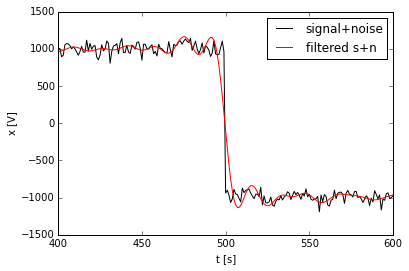

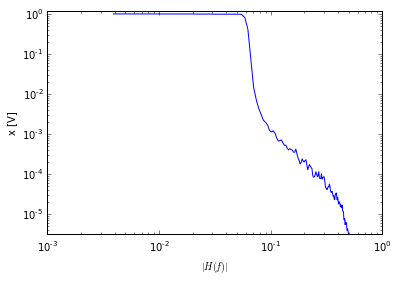

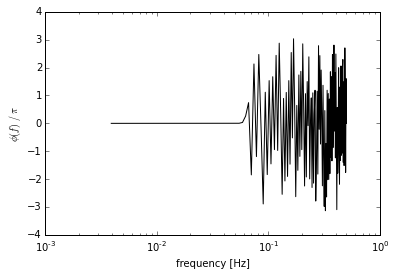

In [68]:
plt.plot(t, xn, '-k', label='signal+noise')
plt.plot(t, y,  '-r', label='filtered s+n')
plt.xlim(400,600) ; plt.legend() ; plt.xlabel('t [s]') ; plt.ylabel('x [V]') ; plt.show()

# low-pass filter, frequency response to be unity at low frequencies and zero at high frequencies
plt.loglog(f, H)
plt.ylim(0,1.2)
plt.xlabel(r'$|H(f)|$') ; plt.ylabel('x [V]') ; plt.show()

plt.semilogx(f, ph, 'k')
plt.ylabel('$\phi(f)\ /\ \pi$') ; plt.xlabel('frequency [Hz]') ; plt.show()

# Comment
decreases ripples, but doubles transition width

<div style='background:#F0F0F0'>**2** Now repeat the above but apply a Hanning window to the frequency window *before* you apply it to the FFT of $x_n$.  Comment on how well the filter is doing when you do this.  (Its helpful to keep the previous result up)  (It is OK to use the `hanning` function)
</div>

In [75]:
# smoothed signal
K = len(f)

fn = ff * 0. + 1e-15
fn[ff < fc] = 1.
fn[ff > 1-fc] = 1.

han = np.hanning(K)  # similar to block 10 in Lecture 7
fn[:K/2] = fn[:K/2] * han[K/2+1:]
fn[N-K/2:] = fn[N-K/2:] * han[:K/2]

#multiply fft by new window
yH = np.real(np.fft.ifft(X*fn))

# spectral response
GyyH, fH = mlab.psd(yH, **args)
HH = np.sqrt(GyyH / (Gxx + Gnn))  # How Jody does it, Lecture 7, block 3
#H = np.sqrt(Gyy/Gxx)

# phase response angle
GyxH, fyxH = mlab.csd(yH, xn, **args);

coh = np.abs(GyxH)**2 / (GyyH * Gxx)
#ph = np.arctan2(np.imag(GyxH), np.real(GyxH)) / np.pi  # Normalized by pi
phH = np.angle(GyxH)

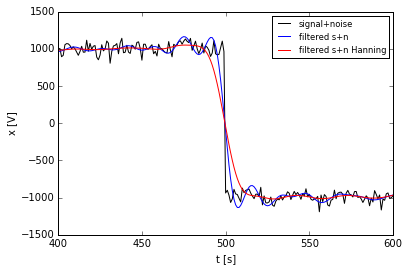

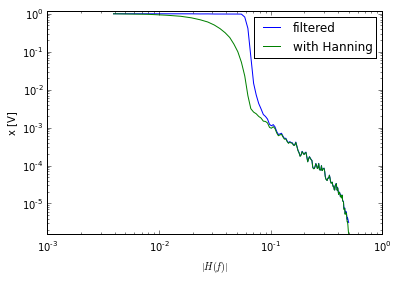

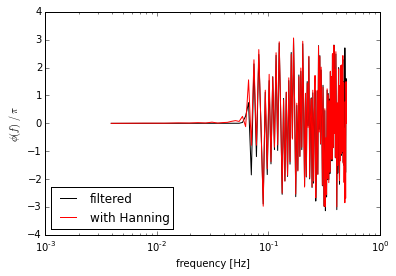

In [76]:
plt.plot(t, xn, '-k', label='signal+noise')
plt.plot(t, y,  '-b', label='filtered s+n')
plt.plot(t, yH,  '-r', label='filtered s+n Hanning')
plt.xlim(400,600) ; plt.legend(fontsize='small') ; plt.xlabel('t [s]') ; plt.ylabel('x [V]') ; plt.show()

# low-pass filter, frequency response to be unity at low frequencies and zero at high frequencies
plt.loglog(f, H, label='filtered')
plt.loglog(fH, HH, label='with Hanning') ; plt.ylim(0,1.2)
plt.legend(fontsize='small') ; plt.legend() ; plt.xlabel(r'$|H(f)|$') ; plt.ylabel('x [V]') ; plt.show()

plt.semilogx(f, ph, 'k', label='filtered')
plt.semilogx(fH, phH, 'r', label='with Hanning')
plt.legend(loc=3) ; plt.ylabel('$\phi(f)\ /\ \pi$') ; plt.xlabel('frequency [Hz]') ; plt.show()

# Comment

<div style='background:#F0F0F0'>**3** So the Hanning window falls off a *lot* earlier and more slowly than a step function, so adjust the cutoff frequency to get a reasonable filter that preserves the amplitude of the sine wave at $f=0.03\ \mathrm{Hz}$.  Comment on the pros and cons of this approach.  
</div>

In [27]:
#make a longer boxcar and longer hanning window
fc2 = 2.0*fc
K2 = 2*K

fn2 = ff * 0. + 1e-15
fn2[(ff < fc2) | (ff > 1-fc2)] = 1.

han2 =  np.hanning(K2)
fn2[:K2/2] = fn2[:K2/2]*han2[K2/2:]
fn2[N-K2/2:] = fn2[N-K2/2:]*han2[:K2/2]
yH2 = np.real(np.fft.ifft(X*fn2))

GyyH2, fH2 = mlab.psd(yH2, **args)
HH2 = np.sqrt(GyyH2 / (Gxx + Gnn))
              
GyxH2, fyxH2 = mlab.csd(yH2, xn, **args)
phH2 = np.angle(GyxH2)

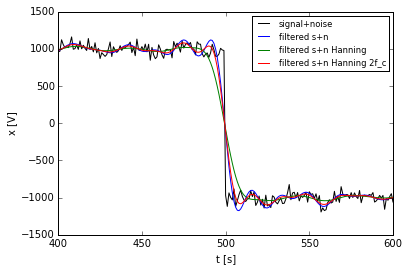

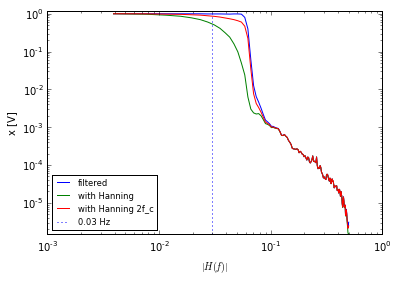

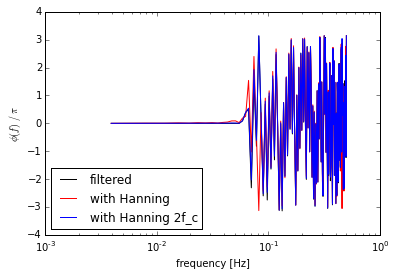

In [31]:
plt.plot(t, xn, '-k', label='signal+noise')
plt.plot(t, y,  '-b', label='filtered s+n')
plt.plot(t, yH,  '-g', label='filtered s+n Hanning')
plt.plot(t, yH2,  '-r', label='filtered s+n Hanning 2f_c')
plt.xlim(400,600) ; plt.legend(fontsize='small') ; plt.xlabel('t [s]') ; plt.ylabel('x [V]') ; plt.show()

# low-pass filter, frequency response to be unity at low frequencies and zero at high frequencies
plt.loglog(f, H, label='filtered')
plt.loglog(fH, HH, label='with Hanning')
plt.loglog(fH, HH2, label='with Hanning 2f_c')
plt.axvline(0.03, label='0.03 Hz', linestyle=':')
plt.ylim(0,1.2)
plt.legend(fontsize='small', loc=3) ; plt.xlabel(r'$|H(f)|$') ; plt.ylabel('x [V]') ; plt.show()

plt.semilogx(f, ph, 'k', label='filtered')
plt.semilogx(fH, phH, 'r', label='with Hanning')
plt.semilogx(fH2, phH2, 'b', label='with Hanning 2f_c')
plt.legend(loc=3) ; plt.ylabel('$\phi(f)\ /\ \pi$') ; plt.xlabel('frequency [Hz]') ; plt.show()

# Comment

## Q2: Implementing a bandpass filter

<div style='background:#F0F0F0'>**1** Create a red-noise process with 20000 data points, $dt=1\ s$.  Using a **truncated Dirichlet Kernel**, create a **bandpass** filter centered at $f_c=0.1\ Hz$ that has a passband that is approximately 0.1 Hz wide. Choose a filter length that is long enough to accomodate 0.1 Hz. 
</div>

   1. Plot the unshifted and shifted filters versus $k$, the time index.
   2. Plot the spectra, the response function $H^2(f)$ and the phase response
   3. Comment on your bandpass and if it indeed passed the right frequencies.

HINT: when you make the Dirichlet Kernel filter make sure that the $k=0$ case is treated "correctly" because $sin(0)=0$ and you will get a discontinuity.  Calculate what $h_0$ should be from [L'Hôpital's_rule](http://en.wikipedia.org/wiki/L'Hôpital's_rule).

In [38]:
N = 20000
t = np.arange(N*1.)
dt = 1.
fc = 0.1
K = N/10

# red noise
x = np.cumsum(np.random.randn(N))
x = x - np.mean(x)

In [60]:
M = fc * 2 * N + 1
k = np.arange(-N/2+1, N/2)
m = np.linspace(-0.5, 0.5, N-1)  # to get width of 0.1:  N/2/10000/2 = 0.5 with N-1 points

# To avoid singularities, add small value (0.000001) to take care of case when k=0
# By l'Hopital's at k=0  h_0 -> M/N  which is approximately the same as for very small values of k
h = (1./N/2) * np.sin(np.pi * (k + 0.000001) * M/N/2) / np.sin(np.pi * (k + 0.000001) /N/2)  # Dirichlet Kernel
h2 = h
h2[(np.abs(k) > (K-1)/2)] = 0.  # Inverse fft of step function
H = np.fft.fftshift(np.fft.fft(h2))

# Shift the filter by convolving H with a delta function in the frequency domain
# convolution in the frequency domain is equvilent to multiplication in the time domain
mm = N * .1
h_sh = 2 * h * np.cos(2 * np.pi * mm * k / N) 

H_sh = np.fft.fftshift(np.fft.fft(h_sh))

# NEED phase response

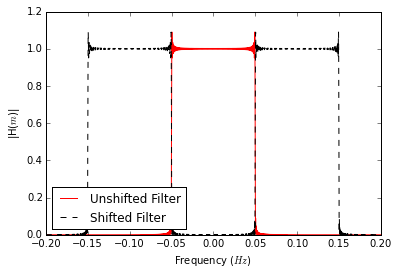

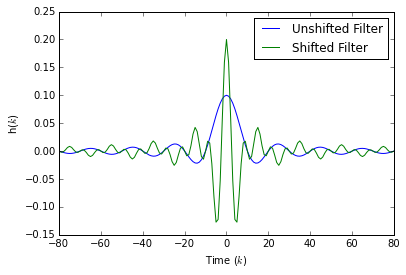

In [62]:
plt.plot(m, abs(H), '-r', label='Unshifted Filter')
plt.plot(m, abs(H_sh), '--k', label='Shifted Filter')
plt.xlim(-0.2,0.2)
plt.legend(loc=3) ; plt.xlabel(r'Frequency ($Hz$)') ; plt.ylabel(r'|H($m$)|') ; plt.show()

plt.plot(k, h, label='Unshifted Filter')
plt.plot(k, h_sh, label = 'Shifted Filter')
plt.xlim(-80,80)
plt.legend() ; plt.ylabel(r'h($k$)') ; plt.xlabel(r'Time ($k$)') ; plt.show()

# Comment

## Q3: Bandpass the weather data

<p><div style='background:#F0F0F0'>
**1** Using `signal.filtfilt` and suitable  "elliptical" filters band-pass the daily signal from the minute-data from Deep Cove.  Plot the power spectrum of the unfiltered and filtered signals. </div>
</p>
<p>
<div style='background:#F0F0F0'>
HINT: Do a high pass and low pass.  Design using `ellipord` and `ellip`.  These functions allow you to try and design a bandpass directly, but I could not get it to work.  Do not be too draconian in your passband - i.e. make it relatively broad, but do try and suppress the peaks.  I found it easier to think in terms of "hours" rather than frequencies, but you can do it as frequencies as well.
</div>
</p>

In [35]:
minutedata = np.genfromtxt('http://web.uvic.ca/~jklymak/Phy411/Data/MinuteData/DeepCoveNew.txt')[:,1]
dc = minutedata[np.isfinite(minutedata)]
dc -= np.mean(dc)

In [79]:
N = len(dc)
fs = 1./60.
fnyq = fs/2.
Nfft = int(N/10.)
args = {'NFFT':Nfft,'Fs':fs,'noverlap':Nfft/2.,'window':mlab.window_hanning}

In [86]:
# Low pass filter
f1 = 1./(24.*3600.)  # inverse of seconds in a day -> frequency
fp = 1.5*f1
fs = 2*f1

n, fn = signal.ellipord(fp/fnyq, fs/fnyq, 1., 40.)
b, a = signal.ellip(n, 1., 40., fn, btype = 'lowpass')
ylow = signal.filtfilt(b, a, dc)
ylow -= ylow

# High pass filter
fp = 0.75*f1
fs = 0.5*f1
n, fn = signal.ellipord(fp/fnyq, fs/fnyq, 1., 40.)
b, a = signal.ellip(n, 1., 40., fn, btype = 'highpass')
yhigh = signal.filtfilt(b, a, dc)

# High pass low pass method
y = signal(b, a, ylow)

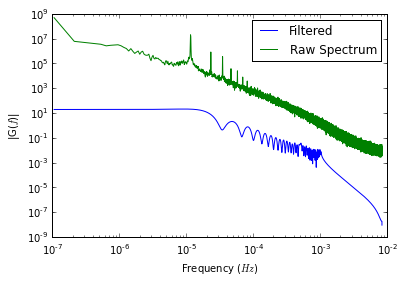

ValueError: x and y must have same first dimension

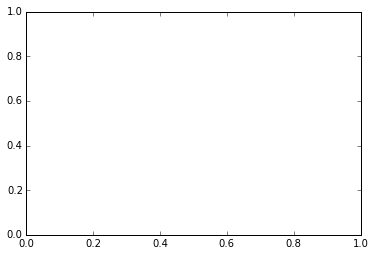

In [90]:
G, f = mlab.psd(dc, **args)
Gfil, ff = mlab.psd(y, **args)

t = np.linspace(0, N*fs, N)

plt.loglog(ff, Gfil, label='Filtered')
plt.loglog(f, G, label='Raw Spectrum')
plt.legend() ; plt.xlabel(r'Frequency ($Hz$)') ; plt.ylabel(r'|G($f$)|') ; plt.show()

plt.plot(t, y)
plt.xlabel('Time (Hours)') ; plt.ylabel('Weather data') ; plt.show()

As an example, suppose we want to have a filter that has no more than 0.1 dB ($H(f)>10^{-0.1/20}=0.9892$) of attenuation below $f_p=0.07 Hz$, and at least 40 dB ($H(f)<10^{-40/20}<0.01$) of attenuation in the stop band above $f_s = 0.12 Hz$.

In [ ]:
dt = 1./60.

# chooose appropriate attenuation cutoff (fp) and attenuation cutoff in stop band (fs)
fp = 
fs = 
fNyq = 1./2./dt

n, fn = signal.ellipord(fp/fNyq, fs/fNyq, .1, 40.)


<div style='background:#F0F0F0'> **2** Using your band passed signal, plot the *amplitude* of the daily cycle as a function of time, smoothed over a suitable time period. Compare with the raw timeseries to make sure your amplitudes make sense. Comment on the annual variation in the daily amplitude and if it makes sense with respect to the seasons.
</div>

# Comment